
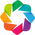

In [1]:
import poloniex
import datetime
import holoviews as hv
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from holoviews.operation.timeseries import rolling, rolling_outlier_std
from holoviews.streams import Stream
hv.notebook_extension('bokeh')
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
def correlacaoretornos(numberofdays, cccode1, cccode2):
    
#funcao que recebe numero de dias (x) e dois codigos de criptocoins
#captura os precos da poloniex em intervalos de 5 minutos iniciando ha x dias ate agora
#plota grafico com os precos de cada uma 
#plota grafico com os retornos de cada uma
#plota grafico dispersao relacionando os retornos ao mesmo tempo e outro com 1 periodo de defasagem
#calcula as correlacoes entre os retornos em cada caso

# 1 - captura dos precos
       
    end = datetime.datetime.now() 
    start = end - datetime.timedelta(numberofdays)
    table1 = poloniex.get_ohlc(cccode1,start, end) 
    table2 = poloniex.get_ohlc(cccode2,start, end)
    closeprice1 = table1['close']
    closeprice2 = table2['close']
    cp1 = np.array(closeprice1)
    cp2 = np.array(closeprice2)
    
# 2 - grafico com precos das duas criptomoedas - com 2 eixos y
    
    plt.figure(figsize=(15,10))
    fig,ax1 = plt.subplots()
    plt.plot(closeprice1,'k',lw=2,label=cccode2)
    plt.grid(True)
    plt.axis('tight')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(cccode1+' x '+cccode2)
    axes = plt.gca()
    ax2=ax1.twinx()
    plt.plot(closeprice2,'b',lw=2,label=cccode2)
    
# 3 - calculo dos retornos e grafico
    
    size1=len(cp1)
    size2=len(cp2)
    return1=cp1[1:]/cp1[:size1-1]-1
    return2=cp2[1:]/cp2[:size2-1]-1

    # grafico 1 
    
    plt.figure(figsize=(15,10))
    plt.plot(return1, 'k', lw=2, label=cccode1)
    plt.plot(return2, 'b', lw=2, label=cccode2)
    plt.grid(True)
    plt.axis('tight')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(cccode1+' x '+cccode2)
    axes = plt.gca()

     # histogramas, separadamente e em conjunto
        
    plt.figure(figsize=(15,10))
    plt.hist(return1,bins=20)
    plt.grid(True)
    plt.axis('tight')
    plt.title(cccode1)
    plt.xlabel('5 minute return value')
    plt.ylabel('frequency')
    
    plt.figure(figsize=(15,10))
    plt.hist(return2,bins=20)
    plt.grid(True)
    plt.axis('tight')
    plt.title(cccode2)
    plt.xlabel('5 minute return value')
    plt.ylabel('frequency')
    
    bins = np.linspace(-.05, .05, 100)
    plt.figure(figsize=(15,10))
    plt.grid(True)
    plt.hist(return1, bins, alpha=0.5, label=cccode1)
    plt.hist(return2, bins, alpha=0.5, label=cccode2)
    plt.legend(loc='upper right')
    plt.title('Histogram '+ cccode1+' x '+cccode2)
    plt.show()
    
# 4 - calculo das correlacoes entre retornos e graficos 
    
    correl0=np.corrcoef(return1,return2)
    correl1=np.corrcoef(return1[1:],return2[:size2-2])
    
    print('correlacao tempo 0 = ', correl0[0,1])
    print('correlacao tempo 1 = ', correl1[0,1])
    
    plt.figure(figsize=(15,10))
    plt.scatter(return1, return2,marker='o')
    plt.grid(True)
    plt.axis('tight')
    plt.xlabel(cccode1+' return')
    plt.ylabel(cccode2+' return')
    plt.title('Retornos lag 0 '+cccode1+' x '+cccode2)
    
    plt.figure(figsize=(15,10))
    plt.scatter(return1[:size1-2], return2[1:],marker='o')
    plt.grid(True)
    plt.axis('tight')
    plt.xlabel(cccode1+'return')
    plt.ylabel(cccode2+'return')
    plt.title('Retornos lag 1 '+cccode1+' x '+cccode2)
    
# Os resultados encontrados demonstram correlacao positiva significativa dos retornos ao mesmo tempo  
# Entretanto, o resultado considerando uma defasagem, que seria o tempo de reacao para se efetuar uma estrategia
# nao eh satisfatorio, pois a correlacao torna-se bastante reduzida.

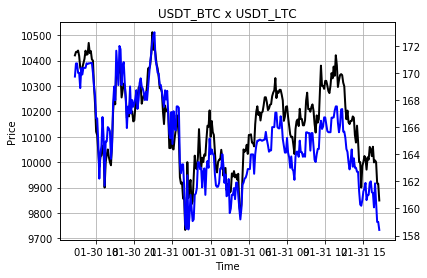

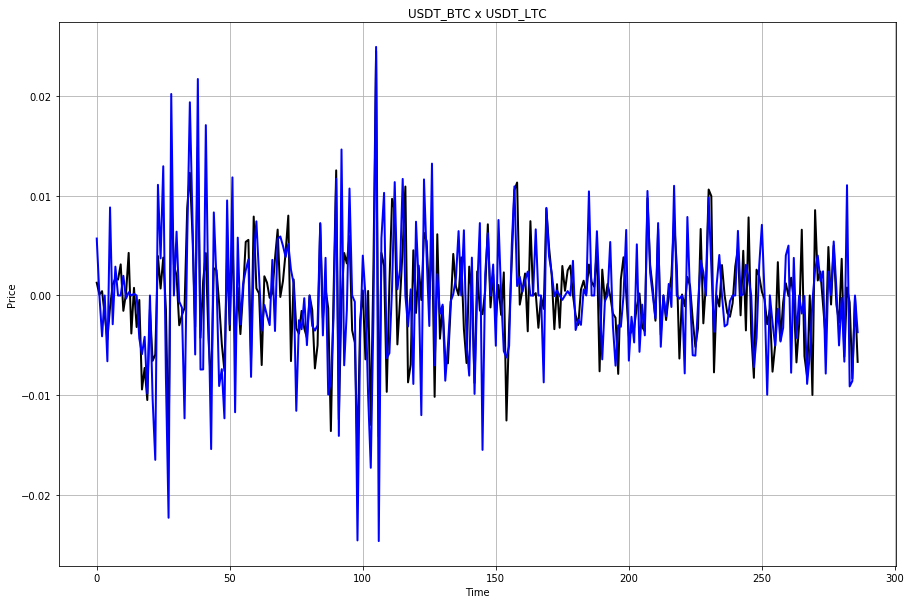

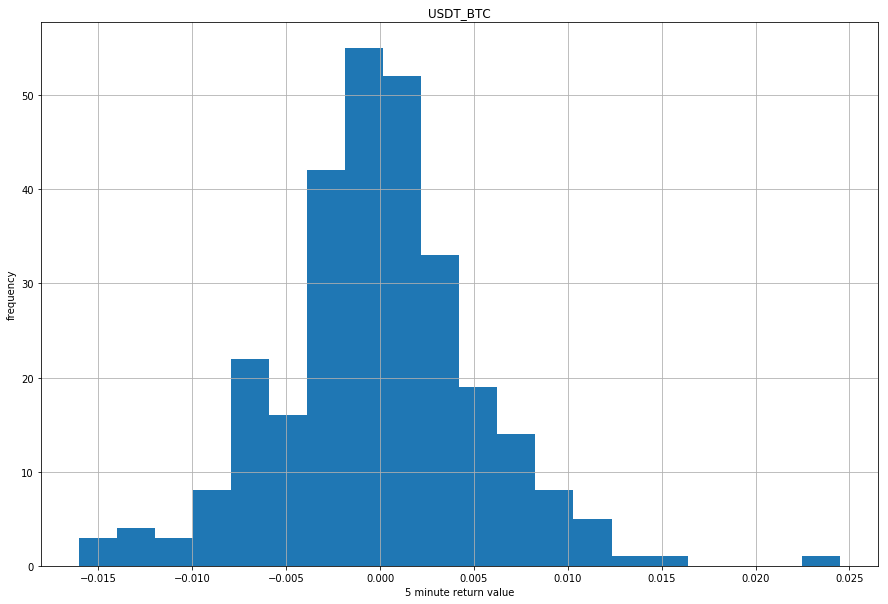

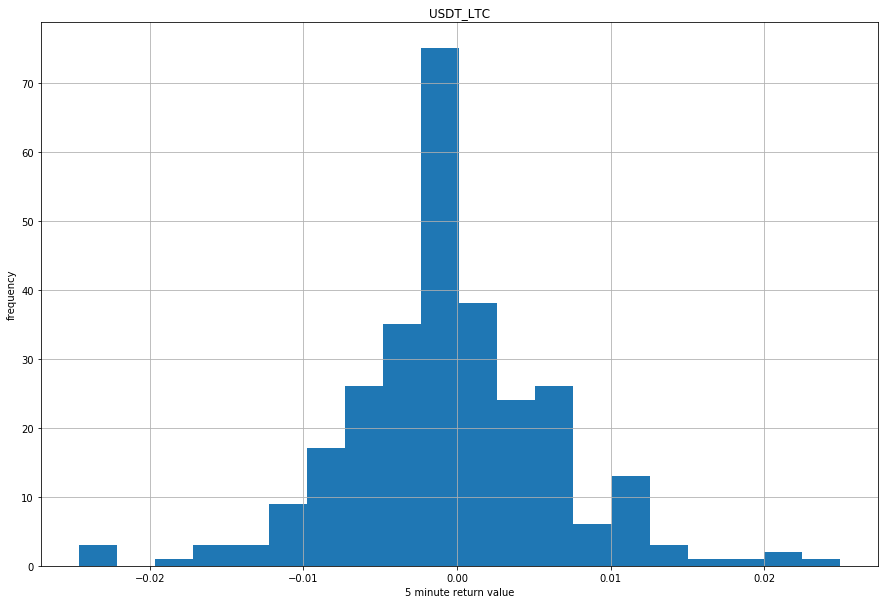

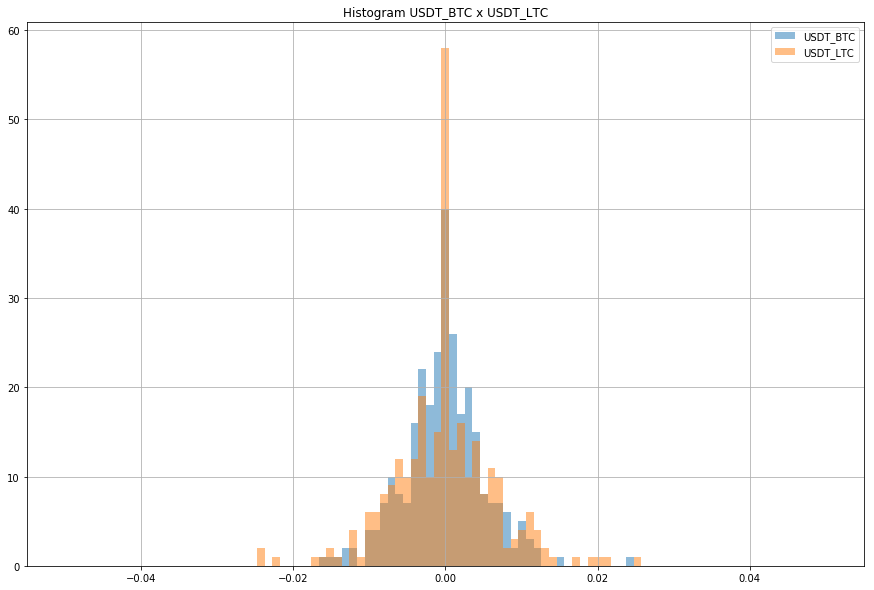

correlacao tempo 0 =  0.695660120082
correlacao tempo 1 =  -0.0546272492953


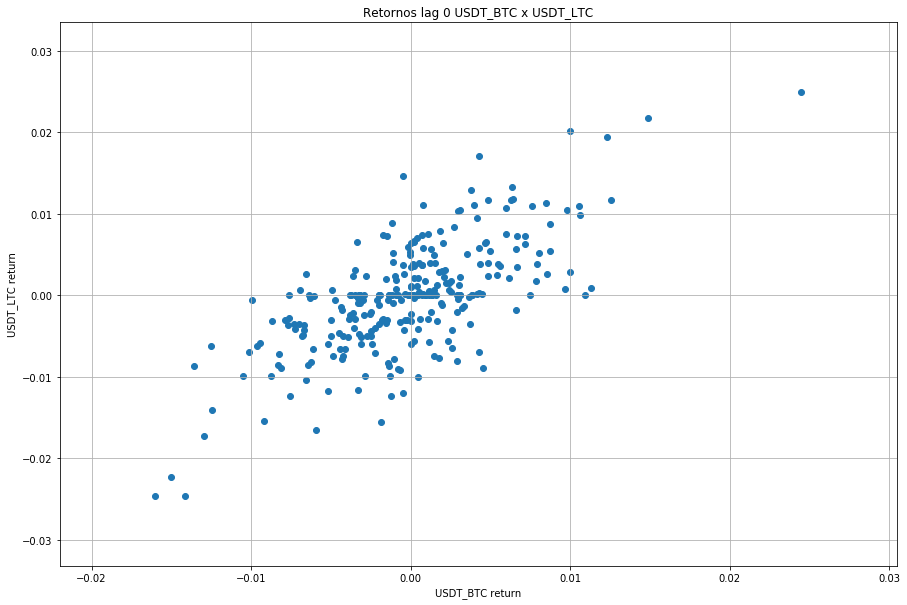

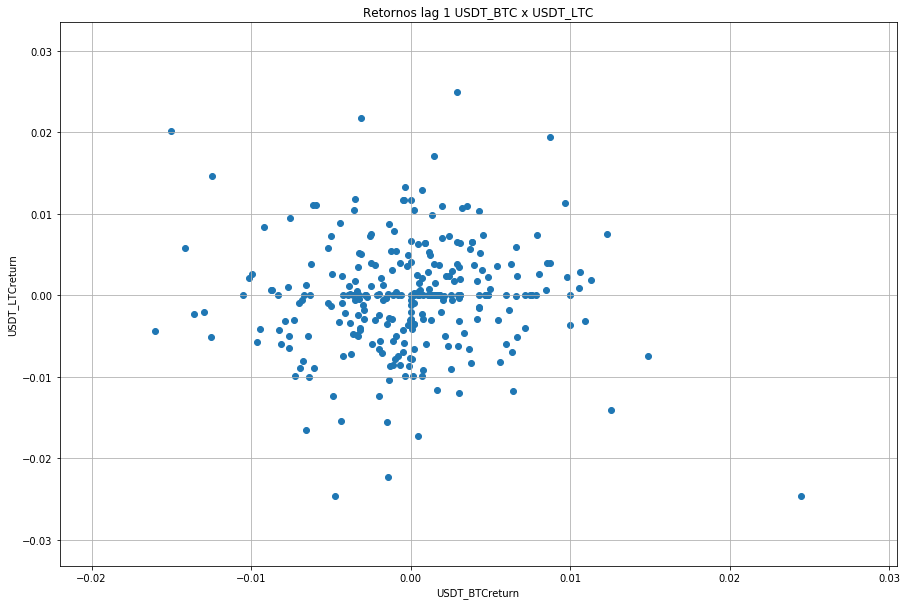

In [49]:
cccode1 = 'USDT_BTC'
cccode2 = 'USDT_LTC'
correlacaoretornos(1, cccode1, cccode2)

In [4]:
def mediamovel(numberofdays, cccode, N):
    
#funcao que recebe numero de dias (numberofdays=x), um codigos de criptocoin, e numero de periodos para media movel (N).
#captura os precos da poloniex em intervalos de 5 minutos iniciando ha x dias ate agora
#calcula a media movel para um periodo de N*5 minutos
#executa estrategia baseada nos sinais de compra e venda dados pelo cruzamento entre a curva de precos e a media movel
#plota grafico com precos, media movel, pontos de compra e venda
#devolve tabela com as operacoes realizadas, retornos e a media dos retornos

# 1 - captura dos precos e calculo da media movel
       
    end = datetime.datetime.now()
    start = end - datetime.timedelta(numberofdays)
    table1 = poloniex.get_ohlc(cccode,start, end)
    closeprice = table1['close']
    cp = np.array(closeprice)
    cumsum = np.cumsum(np.insert(cp, 0, 0)) 
    ma = np.concatenate((np.zeros(N-1),(cumsum[N:] - cumsum[:-N]) / N),axis=0)
    ma1 = pd.DataFrame(ma,index=table1.index)
    
# 2 - estrategia de compra e venda
# Qdo media movel cruza a curva de precos indicando tendencia de subida, ha uma compra
# Se o cruzamento indica queda, eh efetuada a venda
# A primeira operacao eh sempre uma compra
# Se nao houver indicacao de venda ateh o fim, a venda serah feita pelo ultimo preco.

    sinal = cp - ma
    c=np.zeros(len(cp))
    v=np.zeros(len(cp))
    compras=np.array([])
    vendas=np.array([])
    fim=len(cp)
    for t in range(N+1,fim):
        if sinal[t-1]>0 and sinal[t]<0 and sum(c)>0:
            precovenda=cp[t]
            v[t]=precovenda
            vendas = np.append(vendas,precovenda)
        elif sinal[t-1]<0 and sinal[t]>0:
            precocompra=cp[t]
            c[t]=precocompra
            compras = np.append(compras,precocompra)
            
    if len(compras)>len(vendas):
        v[fim-1]=cp[fim-1]
        vendas = np.append(vendas,cp[fim-1])
        
# 3 - Dataframes com os resultados 
                
    buytrades = pd.DataFrame(c)
    buytrades.index=table1.index
    buytrades1=buytrades.loc[(buytrades!=0).any(1)]
    selltrades = pd.DataFrame(v)
    selltrades.index=table1.index
    selltrades1=selltrades.loc[(selltrades!=0).any(1)]
    
# 4 - Media dos retornos, considerando o mesmo volume investido em todas as operacoes
    
    retornos = vendas/compras-1
    mediaretornos=np.mean(retornos)
    
    resultado = pd.DataFrame({"hora compra":buytrades1.index,"preco de compra":compras,"hora venda":selltrades1.index,"preco de venda":vendas,"retorno":retornos})

    print('mediaretornos', mediaretornos)
    
# 5 - Grafico - Curva de precos, media movel, ponto azul para compras, ponto vermelho para vendas
 
    plt.figure(figsize=(15,10))
    plt.plot(closeprice[N:], 'k', lw=2, label='closeprice')
    plt.plot(ma1[N:], 'g', lw=1, linestyle='--')
    plt.plot(buytrades[N:], 'b', marker='o', linestyle='',label='compras')
    plt.plot(selltrades[N:], 'r', marker='o', linestyle='',label='vendas')
    plt.grid(True)
    plt.axis('tight')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title(cccode)
    axes = plt.gca()
    axes.set_ylim([np.min(cp),np.max(cp)])
    
    return resultado
    


mediaretornos -0.00326393647987


,hora compra,hora venda,preco de compra,preco de venda,retorno
0,2018-01-30 03:50:00,2018-01-30 04:05:00,11012.397617,10940.000000,-0.006574
1,2018-01-30 04:10:00,2018-01-30 05:55:00,11009.999998,11004.529588,-0.000497
2,2018-01-30 06:00:00,2018-01-30 06:05:00,11026.727375,11000.000001,-0.002424
3,2018-01-30 06:15:00,2018-01-30 06:35:00,11029.961273,11033.000000,0.000275
4,2018-01-30 06:40:00,2018-01-30 06:45:00,11046.999972,11011.110000,-0.003249
5,2018-01-30 07:40:00,2018-01-30 09:15:00,11063.665879,10990.000000,-0.006658
6,2018-01-30 10:55:00,2018-01-30 11:00:00,10999.000000,10929.355864,-0.006332
7,2018-01-30 11:25:00,2018-01-30 12:45:00,10993.815591,10954.621582,-0.003565
8,2018-01-30 17:10:00,2018-01-30 17:50:00,10438.999999,10301.996805,-0.013124
9,2018-01-30 19:20:00,2018-01-30 20:55:00,10198.919999,10160.528506,-0.003764


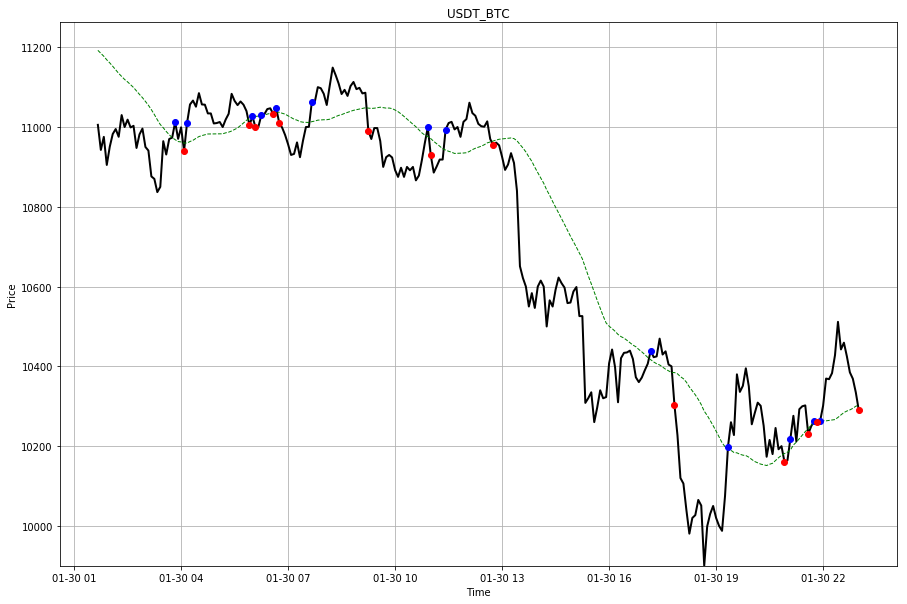

In [5]:
cccode = 'USDT_BTC'
mediamovel(1, cccode, 30)

In [9]:
from sqlalchemy import create_engine

In [10]:
def sqltable(numberofdays, cccode, sqlquery):
    
#funcao que recebe numero de dias (numberofdays=x), um codigo de criptocoin, e uma consulta em sql (sqlquery)
#captura os precos da poloniex em intervalos de 5 minutos iniciando ha x dias ate agora
#devolve a consulta sql nos dados capturados
       
    end = datetime.datetime.now()
    start = end - datetime.timedelta(numberofdays)
    table1 = poloniex.get_ohlc(cccode,start, end)
    conexão = create_engine('sqlite:///btc.sqlite')
    table1sql = pd.read_sql_query(sqlquery, conexão)
    
    return table1sql

In [12]:
cccode = 'USDT_BTC'
sqltable(1, cccode, 'select date,close from poloniex limit 5;')

,date,close
0,2018-01-29 23:30:00.000000,11181.158000
1,2018-01-29 23:35:00.000000,11235.354377
2,2018-01-29 23:40:00.000000,11262.822491
3,2018-01-29 23:45:00.000000,11241.326608
4,2018-01-29 23:50:00.000000,11262.326609
